In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.2 MB/s eta 0:00:00


In [ ]:
!pip install tifffile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import kornia.augmentation as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
BANDS = 100
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, num_bands=100):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands
        self.transform = nn.Sequential(
            K.RandomHorizontalFlip(p=0.3),
            K.RandomVerticalFlip(p=0.3),
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5)
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.base_path}/{row['id']}"

        try:
            # 🔴 FIX DUY NHẤT Ở ĐÂY
            if img_path.lower().endswith('.tif'):
                img = tiff.imread(img_path)
            else:
                img = np.load(img_path)

            # ===== GIỮ NGUYÊN LOGIC GỐC =====
            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            img = img.astype(np.float32) / 65535.0

            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

            if self.augment:
                img = self.transform(img.unsqueeze(0)).squeeze(0)

            if img.shape[1] != self.patch_size or img.shape[2] != self.patch_size:
                img = F.interpolate(
                    img.unsqueeze(0),
                    size=(self.patch_size, self.patch_size),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0)

            label = torch.tensor(row['label'], dtype=torch.long)

            return img, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            dummy_label = torch.tensor(0, dtype=torch.long)
            return dummy_img, dummy_label




class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)


class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=3):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )

        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )

        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x

        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x

        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


(32, 32, 125)


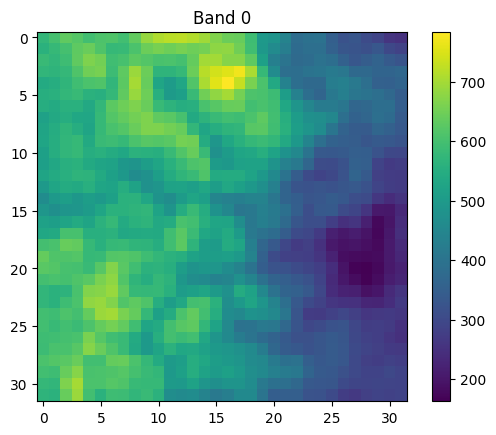

In [ ]:
# sample = np.load('/content/drive/MyDrive/NCKH/challenge/data/train/HS/Health_hyper_1.tif')  # (128, 128, 125)
# plt.imshow(sample[:, :, 0])
# plt.title('First channel')
# plt.colorbar()
# plt.show()

import tifffile as tiff
import matplotlib.pyplot as plt

sample = tiff.imread(
    '/content/drive/MyDrive/NCKH/challenge/data/train/HS/Health_hyper_1.tif'
)  # (128, 128, 125)

print(sample.shape)

plt.imshow(sample[:, :, 0])
plt.title('Band 0')
plt.colorbar()
plt.show()


In [ ]:
path_train = "/content/drive/MyDrive/NCKH/challenge/data/train/HS"
path_test = "/content/drive/MyDrive/NCKH/challenge/data/val/HS"

# Tạo train.csv


In [ ]:
label_map = {
    'Health': 0,
    'Rust': 1,
    'Other': 2
}

records = []

for fname in os.listdir(path_train):
    if not fname.lower().endswith('.tif'):
        continue

    prefix = fname.split('_')[0]   # Health / Rust / Other

    if prefix not in label_map:
        raise ValueError(f'Unknown label in file name: {fname}')

    records.append({
        'id': fname,
        'label': label_map[prefix]
    })

df = pd.DataFrame(records)

print(df.head())
print(df['label'].value_counts())


                     id  label
0    Health_hyper_1.tif      0
1   Health_hyper_10.tif      0
2  Health_hyper_100.tif      0
3  Health_hyper_101.tif      0
4  Health_hyper_102.tif      0
label
0    200
2    200
1    200
Name: count, dtype: int64


In [ ]:
# label_map = {
#     'Health': 0,
#     'Rust': 1,
#     'Other': 2
# }

records = []

for fname in os.listdir(path_test):
    if not fname.lower().endswith('.tif'):
        continue

    records.append({
        'id': fname,
    })

df_test = pd.DataFrame(records)

print(df.head())
print(df['id'].value_counts())


                     id  label
0    Health_hyper_1.tif      0
1   Health_hyper_10.tif      0
2  Health_hyper_100.tif      0
3  Health_hyper_101.tif      0
4  Health_hyper_102.tif      0
id
Rust_hyper_99.tif       1
Health_hyper_1.tif      1
Health_hyper_10.tif     1
Health_hyper_100.tif    1
Health_hyper_101.tif    1
                       ..
Health_hyper_123.tif    1
Health_hyper_124.tif    1
Health_hyper_125.tif    1
Health_hyper_126.tif    1
Health_hyper_127.tif    1
Name: count, Length: 600, dtype: int64


In [ ]:
def evaluate_model(model, loader, criterion, device=DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if i == 0:  # in batch đầu
                print("Logits example:\n", outputs[:5].detach().cpu())

            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)



# def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
#     best_loss = float('inf')
#     train_losses = []
#     val_losses = []

#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
#         valid_samples = 0

#         for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#             inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

#             if torch.isnan(inputs).any() or torch.isnan(labels).any():
#                 continue

#             optimizer.zero_grad()
#             outputs = model(inputs)

#             if torch.isnan(outputs).any():
#                 continue

#             loss = criterion(outputs.squeeze(), labels)

#             if not torch.isnan(loss):
#                 loss.backward()
#                 optimizer.step()
#                 train_loss += loss.item() * inputs.size(0)
#                 valid_samples += inputs.size(0)

#         if valid_samples > 0:
#             train_loss /= valid_samples
#             val_loss, val_preds, val_labels = evaluate_model(model, val_loader, criterion)
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)

#             if len(val_preds.shape) == 2:
#                 val_preds = np.argmax(val_preds, axis=1)

#             print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
#             print(f"Sample predictions: {val_preds[:5]}, True labels: {val_labels[:5]}")


#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 torch.save(model.state_dict(), 'Spectrum_CNN.pth')
#         else:
#             print(f"Epoch {epoch+1}: No valid training samples")

#     plt.figure(figsize=(8, 5))
#     plt.plot(train_losses, label='Train Loss', marker='o')
#     plt.plot(val_losses, label='Validation Loss', marker='o')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     return model


In [ ]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_macro_f1s = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_samples = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue

            optimizer.zero_grad()
            outputs = model(inputs)

            if torch.isnan(outputs).any():
                continue

            loss = criterion(outputs.squeeze(), labels)

            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                valid_samples += inputs.size(0)

        if valid_samples > 0:
            train_loss /= valid_samples

            # ===== VALIDATION =====
            val_loss, val_preds, val_labels = evaluate_model(
                model, val_loader, criterion
            )

            print("Val pred distribution:", np.bincount(val_preds, minlength=3))
            print("Val label distribution:", np.bincount(val_labels, minlength=3))


            # đảm bảo preds là 1D
            if len(val_preds.shape) == 2:
                val_preds = np.argmax(val_preds, axis=1)

            # ===== METRICS =====
            val_acc = accuracy_score(val_labels, val_preds)
            val_macro_f1 = f1_score(val_labels, val_preds, average='macro')

            # ===== SAVE HISTORY =====
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            val_macro_f1s.append(val_macro_f1)

            print(
                f"Epoch {epoch+1}: "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.4f} | "
                f"Val Macro F1: {val_macro_f1:.4f}"
            )

            print(f"Sample predictions: {val_preds[:20]},\n True labels: {val_labels[:20]}")

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'Spectrum_CNN.pth')
        else:
            print(f"Epoch {epoch+1}: No valid training samples")

    # ================= PLOTS =================
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, label='Val Accuracy', marker='o')
    plt.plot(val_macro_f1s, label='Val Macro F1', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


Epoch 1/50: 100%|██████████| 60/60 [00:06<00:00,  9.08it/s]


Logits example:
 tensor([[ 0.8986,  1.1760, -1.0017],
        [ 0.2338,  0.4004, -0.2535],
        [ 0.2672,  0.4578, -0.3003],
        [ 0.3601,  0.5864, -0.4282],
        [ 0.2296,  0.4131, -0.2603]])
Val pred distribution: [ 0 74 46]
Val label distribution: [43 41 36]
Epoch 1: Train Loss: 0.8836 | Val Loss: 0.8379 | Val Acc: 0.5667 | Val Macro F1: 0.4642
Sample predictions: [1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 2/50: 100%|██████████| 60/60 [00:06<00:00,  9.38it/s]


Logits example:
 tensor([[ 0.1078,  0.5360, -0.2758],
        [ 0.0655,  0.4399, -0.2066],
        [ 0.0009,  0.3368, -0.1068],
        [ 0.0610,  0.4501, -0.2069],
        [ 0.0290,  0.3871, -0.1533]])
Val pred distribution: [ 0 77 43]
Val label distribution: [43 41 36]
Epoch 2: Train Loss: 0.8863 | Val Loss: 0.7935 | Val Acc: 0.5833 | Val Macro F1: 0.4764
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 3/50: 100%|██████████| 60/60 [00:05<00:00, 11.43it/s]


Logits example:
 tensor([[ 1.0859,  0.5047, -0.6486],
        [ 0.8363,  0.4862, -0.5552],
        [ 0.1789,  0.3912, -0.2428],
        [ 0.8089,  0.5132, -0.5672],
        [ 0.5815,  0.5275, -0.4958]])
Val pred distribution: [46 28 46]
Val label distribution: [43 41 36]
Epoch 3: Train Loss: 0.8183 | Val Loss: 0.7694 | Val Acc: 0.5583 | Val Macro F1: 0.5564
Sample predictions: [0 0 1 0 0 2 2 0 1 2 0 0 1 0 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 4/50: 100%|██████████| 60/60 [00:06<00:00,  9.30it/s]


Logits example:
 tensor([[ 0.5817,  0.7869, -0.6784],
        [ 0.5717,  0.7192, -0.6393],
        [ 0.0805,  0.3952, -0.1987],
        [ 0.5412,  0.7382, -0.6349],
        [ 0.4495,  0.7136, -0.5736]])
Val pred distribution: [ 5 66 49]
Val label distribution: [43 41 36]
Epoch 4: Train Loss: 0.8441 | Val Loss: 0.7548 | Val Acc: 0.6417 | Val Macro F1: 0.5636
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 5/50: 100%|██████████| 60/60 [00:05<00:00, 11.55it/s]


Logits example:
 tensor([[ 0.6203,  0.6827, -0.6230],
        [ 0.1424,  0.3986, -0.2185],
        [ 0.2959,  0.6205, -0.4373],
        [ 0.2555,  0.5374, -0.3712],
        [ 0.2154,  0.5160, -0.3315]])
Val pred distribution: [ 0 64 56]
Val label distribution: [43 41 36]
Epoch 5: Train Loss: 0.8223 | Val Loss: 0.8070 | Val Acc: 0.5250 | Val Macro F1: 0.4269
Sample predictions: [1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 6/50: 100%|██████████| 60/60 [00:06<00:00,  9.13it/s]


Logits example:
 tensor([[ 1.3987,  1.0770, -1.2915],
        [ 0.7645,  0.6867, -0.7349],
        [ 0.1214,  0.3854, -0.2093],
        [ 0.8036,  0.7660, -0.8014],
        [ 0.5712,  0.6967, -0.6428]])
Val pred distribution: [28 46 46]
Val label distribution: [43 41 36]
Epoch 6: Train Loss: 0.8157 | Val Loss: 0.7503 | Val Acc: 0.5750 | Val Macro F1: 0.5639
Sample predictions: [0 0 1 0 1 2 2 0 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 7/50: 100%|██████████| 60/60 [00:05<00:00, 11.45it/s]


Logits example:
 tensor([[ 0.7626,  0.6740, -0.5881],
        [ 0.3435,  0.5770, -0.4179],
        [ 0.2122,  0.6114, -0.3755],
        [ 0.4208,  0.6252, -0.4672],
        [ 0.3684,  0.6711, -0.4821]])
Val pred distribution: [ 7 66 47]
Val label distribution: [43 41 36]
Epoch 7: Train Loss: 0.7832 | Val Loss: 0.7656 | Val Acc: 0.5917 | Val Macro F1: 0.5266
Sample predictions: [0 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 8/50: 100%|██████████| 60/60 [00:06<00:00,  9.23it/s]


Logits example:
 tensor([[ 0.8125,  0.5376, -0.6361],
        [ 0.4386,  0.4822, -0.4392],
        [ 0.2134,  0.5465, -0.3335],
        [ 0.4988,  0.5138, -0.4868],
        [ 0.4255,  0.5706, -0.4740]])
Val pred distribution: [24 48 48]
Val label distribution: [43 41 36]
Epoch 8: Train Loss: 0.7453 | Val Loss: 0.7819 | Val Acc: 0.5583 | Val Macro F1: 0.5403
Sample predictions: [0 1 1 1 1 2 2 0 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 9/50: 100%|██████████| 60/60 [00:05<00:00, 11.47it/s]


Logits example:
 tensor([[ 0.7826,  0.7432, -0.6705],
        [ 0.8033,  0.2894, -0.4758],
        [ 0.3452,  0.7842, -0.5303],
        [ 0.6547,  0.4548, -0.4901],
        [ 0.5792,  0.4767, -0.4811]])
Val pred distribution: [44 33 43]
Val label distribution: [43 41 36]
Epoch 9: Train Loss: 0.7746 | Val Loss: 0.7709 | Val Acc: 0.5250 | Val Macro F1: 0.5281
Sample predictions: [0 0 1 0 0 2 2 0 1 2 1 1 1 0 2 2 2 2 0 0],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 10/50: 100%|██████████| 60/60 [00:06<00:00,  9.18it/s]


Logits example:
 tensor([[ 1.5922,  1.4416, -1.4469],
        [ 0.7896,  0.8368, -0.7522],
        [ 0.7630,  1.1398, -0.9271],
        [ 0.8726,  0.9676, -0.8629],
        [ 0.7604,  0.9600, -0.8153]])
Val pred distribution: [17 64 39]
Val label distribution: [43 41 36]
Epoch 10: Train Loss: 0.7160 | Val Loss: 0.8275 | Val Acc: 0.5750 | Val Macro F1: 0.5495
Sample predictions: [0 1 1 1 1 2 1 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 11/50: 100%|██████████| 60/60 [00:05<00:00, 10.79it/s]


Logits example:
 tensor([[ 0.3949,  0.5968, -0.4934],
        [ 0.0713,  0.2699, -0.2336],
        [-0.0541,  0.1147,  0.0701],
        [ 0.1825,  0.4704, -0.3407],
        [ 0.1418,  0.4981, -0.3212]])
Val pred distribution: [ 9 63 48]
Val label distribution: [43 41 36]
Epoch 11: Train Loss: 0.7614 | Val Loss: 0.7421 | Val Acc: 0.6333 | Val Macro F1: 0.5745
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 12/50: 100%|██████████| 60/60 [00:06<00:00,  9.24it/s]


Logits example:
 tensor([[ 0.7313,  0.8885, -0.6809],
        [ 0.4409,  0.5497, -0.4579],
        [-0.0701, -0.1519,  0.2993],
        [ 0.4722,  0.7653, -0.5558],
        [ 0.3547,  0.7890, -0.5305]])
Val pred distribution: [10 58 52]
Val label distribution: [43 41 36]
Epoch 12: Train Loss: 0.7657 | Val Loss: 0.7435 | Val Acc: 0.6167 | Val Macro F1: 0.5662
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 13/50: 100%|██████████| 60/60 [00:05<00:00, 11.52it/s]


Logits example:
 tensor([[ 0.5749,  0.9965, -0.6659],
        [ 0.5660,  0.6662, -0.5881],
        [ 0.2318,  0.6662, -0.4046],
        [ 0.4959,  0.8656, -0.5853],
        [ 0.4465,  0.8914, -0.5763]])
Val pred distribution: [ 9 65 46]
Val label distribution: [43 41 36]
Epoch 13: Train Loss: 0.7417 | Val Loss: 0.7265 | Val Acc: 0.6250 | Val Macro F1: 0.5679
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 14/50: 100%|██████████| 60/60 [00:06<00:00,  9.27it/s]


Logits example:
 tensor([[ 1.0259,  0.9828, -0.7877],
        [ 0.0789,  0.3844, -0.1795],
        [ 0.3301,  0.6927, -0.4727],
        [ 0.4711,  0.8606, -0.5972],
        [ 0.2517,  0.6138, -0.3877]])
Val pred distribution: [10 47 63]
Val label distribution: [43 41 36]
Epoch 14: Train Loss: 0.7646 | Val Loss: 0.8306 | Val Acc: 0.5083 | Val Macro F1: 0.4552
Sample predictions: [0 1 1 1 1 2 2 1 1 2 1 1 2 1 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 15/50: 100%|██████████| 60/60 [00:05<00:00, 11.51it/s]


Logits example:
 tensor([[ 1.2540,  1.1412, -0.9307],
        [ 0.5769,  0.7628, -0.5502],
        [ 0.0910,  0.2707, -0.1059],
        [ 0.7210,  0.9502, -0.7010],
        [ 0.5578,  0.8774, -0.6293]])
Val pred distribution: [12 55 53]
Val label distribution: [43 41 36]
Epoch 15: Train Loss: 0.7300 | Val Loss: 0.7441 | Val Acc: 0.6083 | Val Macro F1: 0.5607
Sample predictions: [0 1 1 1 1 2 2 1 1 2 1 1 2 1 2 2 2 2 0 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 16/50: 100%|██████████| 60/60 [00:06<00:00,  9.38it/s]


Logits example:
 tensor([[ 0.6164,  1.0624, -0.7691],
        [-0.1449,  0.0822,  0.0982],
        [-0.0827, -1.0337,  0.9958],
        [ 0.0252,  0.2743, -0.0865],
        [-0.1329, -0.1666,  0.2885]])
Val pred distribution: [ 0 44 76]
Val label distribution: [43 41 36]
Epoch 16: Train Loss: 0.7156 | Val Loss: 0.8634 | Val Acc: 0.4917 | Val Macro F1: 0.3985
Sample predictions: [1 2 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 17/50: 100%|██████████| 60/60 [00:05<00:00, 11.46it/s]


Logits example:
 tensor([[ 0.7004,  1.0101, -0.7528],
        [ 0.4435,  0.8593, -0.5522],
        [ 0.0875,  0.0818,  0.0392],
        [ 0.4730,  0.9703, -0.6330],
        [ 0.4473,  0.9840, -0.6442]])
Val pred distribution: [ 1 70 49]
Val label distribution: [43 41 36]
Epoch 17: Train Loss: 0.7074 | Val Loss: 0.7194 | Val Acc: 0.6000 | Val Macro F1: 0.4912
Sample predictions: [1 1 0 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 18/50: 100%|██████████| 60/60 [00:06<00:00,  9.29it/s]


Logits example:
 tensor([[ 0.3725,  0.8498, -0.5460],
        [ 0.2794,  0.6864, -0.4282],
        [ 0.1567,  0.4050, -0.2210],
        [ 0.3284,  0.7542, -0.4880],
        [ 0.1932,  0.5792, -0.3395]])
Val pred distribution: [ 0 67 53]
Val label distribution: [43 41 36]
Epoch 18: Train Loss: 0.7281 | Val Loss: 0.7659 | Val Acc: 0.5750 | Val Macro F1: 0.4681
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 19/50: 100%|██████████| 60/60 [00:05<00:00, 11.33it/s]


Logits example:
 tensor([[ 0.5279,  0.8945, -0.5986],
        [ 0.3201,  0.7171, -0.4438],
        [ 0.3433,  0.7413, -0.4963],
        [ 0.4174,  0.8468, -0.5436],
        [ 0.3180,  0.7395, -0.4633]])
Val pred distribution: [ 0 68 52]
Val label distribution: [43 41 36]
Epoch 19: Train Loss: 0.7221 | Val Loss: 0.7638 | Val Acc: 0.5750 | Val Macro F1: 0.4687
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 20/50: 100%|██████████| 60/60 [00:06<00:00,  9.17it/s]


Logits example:
 tensor([[ 1.0132,  1.4269, -1.0696],
        [ 0.5460,  0.9454, -0.6771],
        [ 0.0108, -1.0001,  0.9326],
        [ 0.4833,  1.0056, -0.6855],
        [ 0.1658,  0.5340, -0.2962]])
Val pred distribution: [ 7 49 64]
Val label distribution: [43 41 36]
Epoch 20: Train Loss: 0.7040 | Val Loss: 0.8030 | Val Acc: 0.5667 | Val Macro F1: 0.5081
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 21/50: 100%|██████████| 60/60 [00:05<00:00, 11.34it/s]


Logits example:
 tensor([[ 0.5890,  1.0239, -0.6495],
        [ 0.2814,  0.2835, -0.2953],
        [ 0.0387,  0.0507,  0.0674],
        [ 0.3478,  0.6371, -0.4010],
        [ 0.3566,  0.7509, -0.4593]])
Val pred distribution: [15 49 56]
Val label distribution: [43 41 36]
Epoch 21: Train Loss: 0.7147 | Val Loss: 0.7851 | Val Acc: 0.5750 | Val Macro F1: 0.5385
Sample predictions: [1 1 2 1 1 2 2 0 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 22/50: 100%|██████████| 60/60 [00:06<00:00,  9.26it/s]


Logits example:
 tensor([[ 1.3054,  1.3433, -0.9166],
        [ 0.3905,  0.4812, -0.3717],
        [ 0.0908,  0.2252, -0.0708],
        [ 0.5020,  0.8341, -0.5289],
        [ 0.4353,  0.9023, -0.5691]])
Val pred distribution: [14 55 51]
Val label distribution: [43 41 36]
Epoch 22: Train Loss: 0.6949 | Val Loss: 0.7139 | Val Acc: 0.6250 | Val Macro F1: 0.5866
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 23/50: 100%|██████████| 60/60 [00:05<00:00, 11.40it/s]


Logits example:
 tensor([[ 2.6230,  2.4502, -1.9579],
        [ 0.2599,  0.5484, -0.3545],
        [ 0.4010,  0.8371, -0.5727],
        [ 0.5598,  0.8859, -0.5554],
        [ 0.3713,  0.7605, -0.4608]])
Val pred distribution: [ 9 65 46]
Val label distribution: [43 41 36]
Epoch 23: Train Loss: 0.7138 | Val Loss: 0.7442 | Val Acc: 0.5750 | Val Macro F1: 0.5106
Sample predictions: [0 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 24/50: 100%|██████████| 60/60 [00:06<00:00,  9.21it/s]


Logits example:
 tensor([[ 0.9300,  1.1141, -0.7389],
        [ 0.2820,  0.7033, -0.3920],
        [ 0.2286,  0.7237, -0.4201],
        [ 0.3691,  0.8899, -0.4960],
        [ 0.3192,  0.8654, -0.4936]])
Val pred distribution: [ 1 71 48]
Val label distribution: [43 41 36]
Epoch 24: Train Loss: 0.7247 | Val Loss: 0.7178 | Val Acc: 0.5917 | Val Macro F1: 0.4933
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 25/50: 100%|██████████| 60/60 [00:05<00:00, 11.58it/s]


Logits example:
 tensor([[ 0.7928,  0.9813, -0.6662],
        [ 0.2455,  0.4385, -0.3899],
        [ 0.2355,  0.8184, -0.4759],
        [ 0.3271,  0.6158, -0.4197],
        [ 0.2763,  0.6708, -0.4040]])
Val pred distribution: [ 4 69 47]
Val label distribution: [43 41 36]
Epoch 25: Train Loss: 0.7094 | Val Loss: 0.7188 | Val Acc: 0.6083 | Val Macro F1: 0.5218
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 26/50: 100%|██████████| 60/60 [00:06<00:00,  9.08it/s]


Logits example:
 tensor([[ 0.6413,  1.1579, -0.8798],
        [ 0.3475,  0.4135, -0.4419],
        [ 0.1766,  0.2764, -0.1440],
        [ 0.4481,  0.7688, -0.5798],
        [ 0.4425,  0.8048, -0.5843]])
Val pred distribution: [10 61 49]
Val label distribution: [43 41 36]
Epoch 26: Train Loss: 0.7098 | Val Loss: 0.7284 | Val Acc: 0.6250 | Val Macro F1: 0.5683
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 27/50: 100%|██████████| 60/60 [00:05<00:00, 11.58it/s]


Logits example:
 tensor([[ 0.6958,  1.3767, -1.0882],
        [ 0.4348,  0.9198, -0.6592],
        [ 0.1378,  0.3795, -0.2014],
        [ 0.5086,  1.0649, -0.7739],
        [ 0.4209,  0.9640, -0.6770]])
Val pred distribution: [ 0 71 49]
Val label distribution: [43 41 36]
Epoch 27: Train Loss: 0.7055 | Val Loss: 0.7253 | Val Acc: 0.6083 | Val Macro F1: 0.4950
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 28/50: 100%|██████████| 60/60 [00:06<00:00,  9.06it/s]


Logits example:
 tensor([[ 1.0009,  1.2081, -1.0285],
        [ 0.4505,  0.7320, -0.5553],
        [ 0.2015,  0.5715, -0.3497],
        [ 0.5926,  1.0421, -0.7656],
        [ 0.5314,  1.0901, -0.7780]])
Val pred distribution: [ 2 63 55]
Val label distribution: [43 41 36]
Epoch 28: Train Loss: 0.6866 | Val Loss: 0.7843 | Val Acc: 0.5833 | Val Macro F1: 0.4873
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 2 1 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 29/50: 100%|██████████| 60/60 [00:05<00:00, 11.38it/s]


Logits example:
 tensor([[ 1.7622,  2.5828, -1.8804],
        [ 0.6811,  0.7430, -0.5995],
        [ 0.5649,  1.4912, -0.9871],
        [ 0.7276,  1.2997, -0.8450],
        [ 0.6158,  1.3523, -0.8666]])
Val pred distribution: [10 67 43]
Val label distribution: [43 41 36]
Epoch 29: Train Loss: 0.7027 | Val Loss: 0.7380 | Val Acc: 0.6167 | Val Macro F1: 0.5673
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 30/50: 100%|██████████| 60/60 [00:06<00:00,  9.19it/s]


Logits example:
 tensor([[ 0.8272,  1.0058, -0.5622],
        [ 1.0058,  0.2397, -0.3989],
        [-0.0714, -0.1654,  0.2696],
        [ 0.5320,  0.6772, -0.4139],
        [ 0.3887,  0.8347, -0.4949]])
Val pred distribution: [25 44 51]
Val label distribution: [43 41 36]
Epoch 30: Train Loss: 0.6898 | Val Loss: 0.7235 | Val Acc: 0.6333 | Val Macro F1: 0.6178
Sample predictions: [1 0 2 1 1 2 2 0 1 2 0 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 31/50: 100%|██████████| 60/60 [00:05<00:00, 11.65it/s]


Logits example:
 tensor([[ 0.5852,  1.3110, -0.7948],
        [ 0.3166,  0.9241, -0.5354],
        [-0.1090, -0.2676,  0.3597],
        [ 0.1230,  0.6750, -0.3546],
        [-0.0093,  0.4295, -0.1640]])
Val pred distribution: [ 0 59 61]
Val label distribution: [43 41 36]
Epoch 31: Train Loss: 0.7137 | Val Loss: 0.7615 | Val Acc: 0.5583 | Val Macro F1: 0.4537
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 32/50: 100%|██████████| 60/60 [00:06<00:00,  9.21it/s]


Logits example:
 tensor([[ 0.9803,  1.3284, -0.7227],
        [ 0.3295,  0.7697, -0.4271],
        [ 0.1524,  0.5323, -0.2888],
        [ 0.5533,  1.1048, -0.6950],
        [ 0.4668,  1.0349, -0.6676]])
Val pred distribution: [ 1 71 48]
Val label distribution: [43 41 36]
Epoch 32: Train Loss: 0.7118 | Val Loss: 0.7144 | Val Acc: 0.6167 | Val Macro F1: 0.5132
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 33/50: 100%|██████████| 60/60 [00:05<00:00, 11.71it/s]


Logits example:
 tensor([[ 0.6843,  1.4598, -0.9520],
        [ 0.3867,  0.9128, -0.6405],
        [-0.0385, -1.4476,  1.3192],
        [ 0.1895,  0.5346, -0.3119],
        [ 0.0469,  0.1792, -0.0053]])
Val pred distribution: [ 0 44 76]
Val label distribution: [43 41 36]
Epoch 33: Train Loss: 0.6762 | Val Loss: 1.0025 | Val Acc: 0.4667 | Val Macro F1: 0.3749
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 34/50: 100%|██████████| 60/60 [00:06<00:00,  9.12it/s]


Logits example:
 tensor([[ 0.5204,  1.0622, -0.5936],
        [ 0.0839,  0.5006, -0.2709],
        [-0.0773, -0.8090,  0.7946],
        [ 0.3019,  0.8088, -0.5147],
        [ 0.1615,  0.6575, -0.3909]])
Val pred distribution: [ 1 60 59]
Val label distribution: [43 41 36]
Epoch 34: Train Loss: 0.7186 | Val Loss: 0.7505 | Val Acc: 0.5750 | Val Macro F1: 0.4782
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 35/50: 100%|██████████| 60/60 [00:05<00:00, 11.49it/s]


Logits example:
 tensor([[ 0.6251,  1.1570, -0.8020],
        [ 0.3350,  0.7752, -0.4987],
        [ 0.2210,  0.3111, -0.1794],
        [ 0.5841,  1.1837, -0.8260],
        [ 0.5784,  1.2042, -0.8467]])
Val pred distribution: [ 2 68 50]
Val label distribution: [43 41 36]
Epoch 35: Train Loss: 0.6838 | Val Loss: 0.7025 | Val Acc: 0.6167 | Val Macro F1: 0.5223
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 36/50: 100%|██████████| 60/60 [00:06<00:00,  8.94it/s]


Logits example:
 tensor([[ 1.0998,  0.9677, -0.7364],
        [ 0.6491, -0.1175, -0.5326],
        [ 0.4340,  0.8422, -0.5977],
        [ 0.5413,  0.5586, -0.4703],
        [ 0.4292,  0.6464, -0.4677]])
Val pred distribution: [32 40 48]
Val label distribution: [43 41 36]
Epoch 36: Train Loss: 0.6699 | Val Loss: 0.7277 | Val Acc: 0.6083 | Val Macro F1: 0.6013
Sample predictions: [0 0 1 1 1 2 2 0 1 2 0 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 37/50: 100%|██████████| 60/60 [00:05<00:00, 11.45it/s]


Logits example:
 tensor([[ 0.6819,  0.8867, -0.6568],
        [ 0.3075,  0.4295, -0.3277],
        [ 0.2310,  0.5099, -0.3029],
        [ 0.4606,  0.9285, -0.5977],
        [ 0.4208,  0.9806, -0.6249]])
Val pred distribution: [10 61 49]
Val label distribution: [43 41 36]
Epoch 37: Train Loss: 0.6707 | Val Loss: 0.6998 | Val Acc: 0.6417 | Val Macro F1: 0.5874
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 38/50: 100%|██████████| 60/60 [00:06<00:00,  9.34it/s]


Logits example:
 tensor([[ 0.6022,  0.9624, -0.7109],
        [ 0.3380,  0.8052, -0.5059],
        [ 0.1050, -0.1456,  0.2130],
        [ 0.4811,  1.1773, -0.7943],
        [ 0.4535,  1.2081, -0.7957]])
Val pred distribution: [ 4 61 55]
Val label distribution: [43 41 36]
Epoch 38: Train Loss: 0.6802 | Val Loss: 0.7135 | Val Acc: 0.5917 | Val Macro F1: 0.5131
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 1 0 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 39/50: 100%|██████████| 60/60 [00:05<00:00, 11.45it/s]


Logits example:
 tensor([[ 0.8164,  1.4750, -1.1124],
        [ 0.4499,  0.6139, -0.4871],
        [ 0.2165,  0.6695, -0.3752],
        [ 0.5210,  1.1505, -0.7831],
        [ 0.4285,  1.1444, -0.7322]])
Val pred distribution: [ 9 63 48]
Val label distribution: [43 41 36]
Epoch 39: Train Loss: 0.7081 | Val Loss: 0.6893 | Val Acc: 0.6167 | Val Macro F1: 0.5537
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 40/50: 100%|██████████| 60/60 [00:06<00:00,  9.14it/s]


Logits example:
 tensor([[ 0.6649,  1.0245, -0.7780],
        [ 0.2053,  0.2249, -0.3216],
        [ 0.1598, -1.0855,  0.8626],
        [ 0.4519,  0.7979, -0.5459],
        [ 0.3369,  0.9310, -0.5900]])
Val pred distribution: [18 49 53]
Val label distribution: [43 41 36]
Epoch 40: Train Loss: 0.6567 | Val Loss: 0.7868 | Val Acc: 0.6000 | Val Macro F1: 0.5678
Sample predictions: [1 1 2 1 1 2 2 0 1 2 0 1 1 0 2 2 2 2 0 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 41/50: 100%|██████████| 60/60 [00:05<00:00, 11.45it/s]


Logits example:
 tensor([[ 0.5617,  0.9467, -0.6278],
        [ 0.9100, -0.0665, -0.7620],
        [ 0.4272,  1.2154, -0.7336],
        [ 0.3610,  0.6188, -0.4554],
        [ 0.3204,  0.6672, -0.4540]])
Val pred distribution: [31 47 42]
Val label distribution: [43 41 36]
Epoch 41: Train Loss: 0.7295 | Val Loss: 0.7576 | Val Acc: 0.5917 | Val Macro F1: 0.5875
Sample predictions: [1 0 1 1 1 2 2 0 1 2 0 1 1 1 2 2 2 2 0 0],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 42/50: 100%|██████████| 60/60 [00:06<00:00,  9.25it/s]


Logits example:
 tensor([[ 1.1676,  1.6552, -1.3575],
        [ 0.1683,  0.7787, -0.4318],
        [ 0.1524,  0.3255, -0.1394],
        [ 0.5066,  1.1310, -0.7547],
        [ 0.4607,  1.0977, -0.7185]])
Val pred distribution: [ 2 64 54]
Val label distribution: [43 41 36]
Epoch 42: Train Loss: 0.6781 | Val Loss: 0.7102 | Val Acc: 0.6083 | Val Macro F1: 0.5153
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 2 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 43/50: 100%|██████████| 60/60 [00:05<00:00, 11.48it/s]


Logits example:
 tensor([[ 0.9903,  1.3674, -1.1201],
        [ 0.3472,  0.6464, -0.4742],
        [ 0.1794, -1.1180,  0.8502],
        [ 0.4867,  1.0307, -0.7149],
        [ 0.3629,  0.9503, -0.6160]])
Val pred distribution: [ 5 57 58]
Val label distribution: [43 41 36]
Epoch 43: Train Loss: 0.6725 | Val Loss: 0.7617 | Val Acc: 0.5583 | Val Macro F1: 0.4866
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 1 2 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 44/50: 100%|██████████| 60/60 [00:06<00:00,  9.23it/s]


Logits example:
 tensor([[ 3.4512,  3.5380, -3.3494],
        [ 0.8619,  1.0764, -0.8741],
        [ 0.8489,  1.5806, -1.3054],
        [ 1.3551,  1.8509, -1.6446],
        [ 1.1257,  1.7589, -1.5399]])
Val pred distribution: [15 63 42]
Val label distribution: [43 41 36]
Epoch 44: Train Loss: 0.6719 | Val Loss: 0.7476 | Val Acc: 0.6250 | Val Macro F1: 0.5885
Sample predictions: [1 1 1 1 1 2 2 1 1 2 0 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 45/50: 100%|██████████| 60/60 [00:05<00:00, 11.33it/s]


Logits example:
 tensor([[ 0.7967,  1.3670, -1.1183],
        [ 0.2925,  0.9011, -0.5817],
        [ 0.1749, -1.3022,  1.0286],
        [ 0.2939,  0.7870, -0.5221],
        [ 0.1991,  0.5707, -0.3444]])
Val pred distribution: [ 4 54 62]
Val label distribution: [43 41 36]
Epoch 45: Train Loss: 0.6608 | Val Loss: 0.8219 | Val Acc: 0.5417 | Val Macro F1: 0.4634
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 1 2],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 46/50: 100%|██████████| 60/60 [00:06<00:00,  9.19it/s]


Logits example:
 tensor([[ 1.9318,  2.1471, -1.7144],
        [ 0.3533,  0.5512, -0.4159],
        [ 0.4106,  1.0024, -0.6858],
        [ 0.6702,  1.2115, -0.9174],
        [ 0.6224,  1.2791, -0.9727]])
Val pred distribution: [14 62 44]
Val label distribution: [43 41 36]
Epoch 46: Train Loss: 0.7154 | Val Loss: 0.7082 | Val Acc: 0.6250 | Val Macro F1: 0.5849
Sample predictions: [1 1 1 1 1 2 2 0 1 2 0 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 47/50: 100%|██████████| 60/60 [00:05<00:00, 11.25it/s]


Logits example:
 tensor([[ 1.9062,  2.2529, -2.1256],
        [ 0.3995,  0.7840, -0.5799],
        [ 0.0877, -0.7680,  0.6670],
        [ 0.7266,  1.3764, -1.1112],
        [ 0.4946,  1.1767, -0.8617]])
Val pred distribution: [10 60 50]
Val label distribution: [43 41 36]
Epoch 47: Train Loss: 0.6756 | Val Loss: 0.7433 | Val Acc: 0.5917 | Val Macro F1: 0.5294
Sample predictions: [1 1 2 1 1 2 2 1 1 2 1 1 1 0 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 48/50: 100%|██████████| 60/60 [00:06<00:00,  9.16it/s]


Logits example:
 tensor([[ 1.5536,  1.6244, -1.2897],
        [ 0.6044,  0.9226, -0.5935],
        [ 0.4803,  1.1823, -0.7368],
        [ 0.7652,  1.2144, -0.8478],
        [ 0.6969,  1.3427, -0.9235]])
Val pred distribution: [ 4 71 45]
Val label distribution: [43 41 36]
Epoch 48: Train Loss: 0.7071 | Val Loss: 0.7195 | Val Acc: 0.6000 | Val Macro F1: 0.5157
Sample predictions: [1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 49/50: 100%|██████████| 60/60 [00:05<00:00, 11.37it/s]


Logits example:
 tensor([[ 0.5168,  1.0472, -0.6700],
        [ 0.3984,  0.7312, -0.4780],
        [ 0.0692,  0.2690, -0.0483],
        [ 0.3850,  1.0752, -0.6347],
        [ 0.3395,  1.1040, -0.6104]])
Val pred distribution: [ 6 65 49]
Val label distribution: [43 41 36]
Epoch 49: Train Loss: 0.6904 | Val Loss: 0.7059 | Val Acc: 0.6417 | Val Macro F1: 0.5706
Sample predictions: [1 1 1 1 1 2 2 1 1 2 0 1 1 1 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


Epoch 50/50: 100%|██████████| 60/60 [00:06<00:00,  9.21it/s]


Logits example:
 tensor([[ 0.6636,  0.9627, -0.7005],
        [ 0.5092,  0.5319, -0.4829],
        [ 0.1513,  0.3747, -0.1520],
        [ 0.4910,  1.2616, -0.8083],
        [ 0.4397,  1.2992, -0.7867]])
Val pred distribution: [16 56 48]
Val label distribution: [43 41 36]
Epoch 50: Train Loss: 0.6694 | Val Loss: 0.7388 | Val Acc: 0.6417 | Val Macro F1: 0.6075
Sample predictions: [1 1 1 1 1 2 2 1 1 2 0 1 1 0 2 2 2 2 1 1],
 True labels: [0 1 1 0 0 2 0 1 0 2 0 0 0 1 2 2 0 2 0 0]


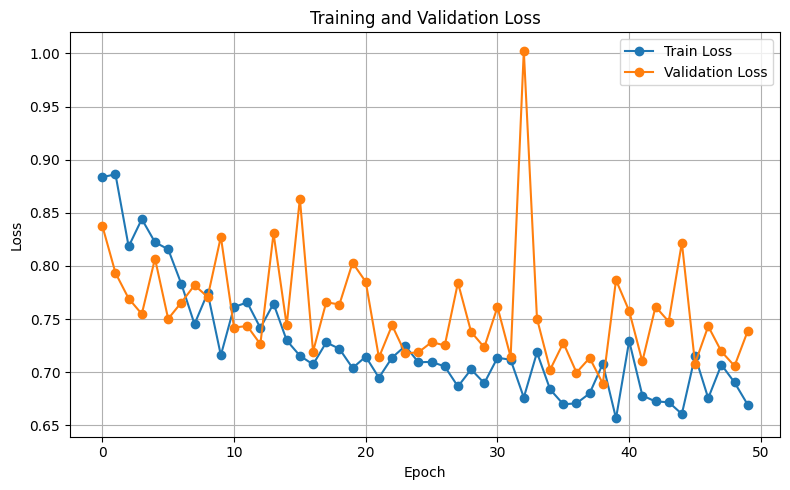

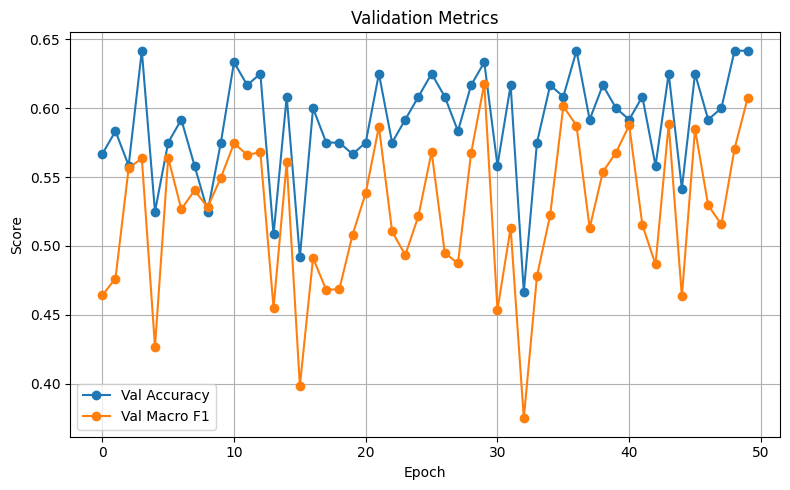

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def main():
    train_df = df
    base_path = "/content/drive/MyDrive/NCKH/challenge/data/train/HS"

    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

    train_dataset = HyperspectralDataset(train_df, base_path, augment=True)
    val_dataset = HyperspectralDataset(val_df, base_path, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = HyperspectralCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 2.0]).to(DEVICE))
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)

    model.load_state_dict(torch.load('Spectrum_CNN.pth'))

    return model

if __name__ == '__main__':
    model = main()

In [ ]:
train_df = df
base_path = "/content/drive/MyDrive/NCKH/challenge/data/train/HS"

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


print("Train label counts:")
print(train_df["label"].value_counts())

print("\nVal label counts:")
print(val_df["label"].value_counts())


train_dataset = HyperspectralDataset(train_df, base_path, augment=True)
val_dataset = HyperspectralDataset(val_df, base_path, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Train label counts:
label
2    160
0    160
1    160
Name: count, dtype: int64

Val label counts:
label
0    40
1    40
2    40
Name: count, dtype: int64


In [ ]:
import torch
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for id, labels in val_loader:
        id = id.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(id)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)


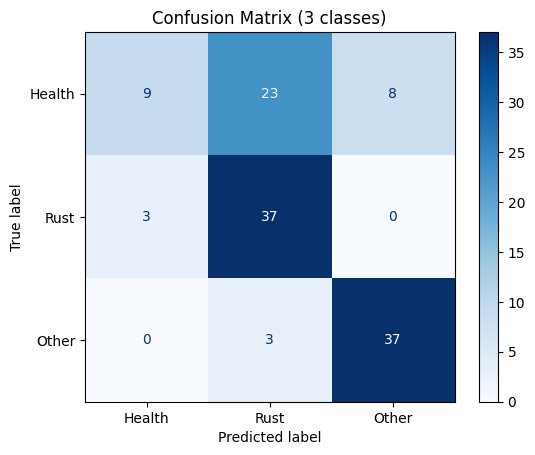

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=[0, 1, 2]   # 🚨 ép đủ 3 lớp
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Health", "Rust", "Other"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (3 classes)")
plt.show()


In [ ]:
model = HyperspectralCNN(in_channels=100).to(DEVICE)
model.load_state_dict(torch.load('Spectrum_CNN.pth'))
model.eval()
print("Model weights:", list(model.parameters())[0][0, 0, :5])
test_input = torch.randn(1, 100, 64, 64).to(DEVICE)

class TestHyperspectralDataset(Dataset):
    def __init__(self, test_csv, base_path, patch_size=64, num_bands=100):
        self.df = pd.read_csv(test_csv)
        self.base_path = base_path
        self.patch_size = patch_size
        self.num_bands = num_bands

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['id'])

        try:
            img = np.load(img_path)

            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            normalized_img = np.zeros_like(img)
            for band in range(img.shape[2]):
                band_data = img[:, :, band]
                if np.max(band_data) > 0:
                    normalized_img[:, :, band] = (band_data - np.min(band_data)) / (np.max(band_data) - np.min(band_data))

            img_tensor = torch.tensor(normalized_img, dtype=torch.float32).permute(2, 0, 1)

            if img_tensor.shape[1] != self.patch_size or img_tensor.shape[2] != self.patch_size:
                img_tensor = F.interpolate(img_tensor.unsqueeze(0),
                                         size=(self.patch_size, self.patch_size),
                                         mode='bilinear').squeeze(0)

            return img_tensor, row['id']

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            return dummy_img, row['id']


test_csv_path = df_test
base_path = "/content/drive/MyDrive/NCKH/challenge/data/val/HS"

test_dataset = TestHyperspectralDataset(test_csv_path, base_path, num_bands=100)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictions = []
ids = []

with torch.no_grad():
    for inputs, img_ids in test_loader:
        inputs = inputs.to(DEVICE)

        if torch.isnan(inputs).any():
            print(f"Skipping batch with NaN values")
            predictions.extend([50] * len(img_ids))
            ids.extend(img_ids)
            continue

        outputs = model(inputs)
        preds = outputs.squeeze().cpu().numpy()
        print(preds)
        preds = np.clip(preds, 1, 100).round().astype(int)
        print(preds)
        if isinstance(preds, np.ndarray) and preds.ndim > 1:
            preds = np.max(preds, axis=1)

        if len(preds) != len(img_ids):
            preds = preds[:len(img_ids)]

        predictions.extend(preds.tolist())
        ids.extend(img_ids)



submission_df = pd.DataFrame({'ID': ids, 'TARGET': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission created successfully")
print("\nSubmission preview:")
print(submission_df.head())

Model weights: tensor([[0.1336, 0.1561, 0.1427],
        [0.1334, 0.1175, 0.1281],
        [0.1615, 0.1552, 0.1493]], device='cuda:0', grad_fn=<SelectBackward0>)


TypeError: argument of type 'method' is not iterable